In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, precision_recall_curve

2025-02-23 14:40:17.053748: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-23 14:40:17.061166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740318017.069880   20964 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740318017.072604   20964 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-23 14:40:17.082406: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1e-8
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = alpha * y_true + (1 - alpha) * (1 - y_true)
        loss = weight * tf.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(loss)
    return focal_loss_fixed

In [3]:
df=pd.read_csv("datasets/sensor.csv")
sensors_to_drop = ['Unnamed: 0', 'timestamp','sensor_15', 'sensor_50']
df = df.drop(columns=sensors_to_drop)

sensor_cols = df.columns[df.isnull().any()].tolist()
df[sensor_cols] = df[sensor_cols].interpolate(method='linear')

# If any remaining NaNs, use forward/backward fill
df[sensor_cols] = df[sensor_cols].fillna(method='ffill')
df[sensor_cols] = df[sensor_cols].fillna(method='bfill')
y=df["machine_status"]
X=df.drop(columns=['machine_status'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

/tmp/ipykernel_20964/3937112226.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[sensor_cols] = df[sensor_cols].fillna(method='ffill')
/tmp/ipykernel_20964/3937112226.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[sensor_cols] = df[sensor_cols].fillna(method='bfill')


In [4]:
def create_sequences(X, y, window_size=60, horizon=30):
    X_seq = []
    y_seq = []
    n_samples = X.shape[0]
    for i in range(n_samples - window_size - horizon + 1):
        # Get a window of sensor readings
        x_window = X[i:i+window_size]
        # Look ahead over the prediction horizon
        future_labels = y[i+window_size:i+window_size+horizon]
        # If any future label is "BROKEN", mark the entire window as a pre-failure event.
        label = 1 if np.any(future_labels == "BROKEN") else 0
        X_seq.append(x_window)
        y_seq.append(label)
    return np.array(X_seq), np.array(y_seq)
# Define window size (e.g. last 60 minutes) and prediction horizon (e.g. next 30 minutes)
window_size = 60   # adjust based on domain knowledge
horizon = 30       # how far ahead we want to predict
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size, horizon)
X_test_seq, y_test_seq   = create_sequences(X_test, y_test, window_size, horizon)

In [5]:
n_samples, time_steps, n_features = X_train_seq.shape
X_train_2d = X_train_seq.reshape((n_samples, time_steps * n_features))
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_2d, y_train_seq)
X_train_seq_resampled = X_resampled.reshape((-1, time_steps, n_features))

In [6]:
unique_classes = np.unique(y_train_seq)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_seq)
class_weights_dict = {i: weight for i, weight in zip(unique_classes, class_weights)}
print("Class weights:", class_weights_dict)

Class weights: {0: 0.5005456976289439, 1: 458.62916666666666}


In [7]:
model = Sequential([
    LSTM(128, input_shape=(time_steps, n_features), return_sequences=True,
         kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    Dropout(0.3),
    LSTM(64, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss=focal_loss(), optimizer='adam', metrics=['accuracy'])
model.summary()

2025-02-23 14:40:22.426755: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1740318022.427679   20964 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4059 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/henrik/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        91,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,121 (551.25 KB)

 Trainable params: 141,121 (551.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = model.fit(
    X_train_seq_resampled, y_resampled,
    epochs=50,
    batch_size=128,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stop]
)

Epoch 1/50


I0000 00:00:1740318026.035187   21076 cuda_dnn.cc:529] Loaded cuDNN version 90300


1718/1718 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.4994 - loss: 0.0065 - val_accuracy: 8.1765e-04 - val_loss: 1.1712e-05
Epoch 2/50
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4990 - loss: 4.4274e-06 - val_accuracy: 8.1765e-04 - val_loss: 2.9836e-08
Epoch 3/50
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4997 - loss: 5.5784e-08 - val_accuracy: 8.1765e-04 - val_loss: 1.0648e-08
Epoch 4/50
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4992 - loss: 2.6674e-08 - val_accuracy: 8.1765e-04 - val_loss: 4.8880e-09
Epoch 5/50
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5006 - loss: 1.3437e-08 - val_accuracy: 8.1765e-04 - val_loss: 2.2346e-09
Epoch 6/50
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5001 - loss: 7.6462e-09 - val_accuracy: 8.1765e-04 - val_loss: 9.2522e-10
Epoch 7/50
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5018 - loss: 3.6636e-09 - val_accuracy: 8.1765e-04 - val_loss: 3.9800e-10
Epoch 8/50
1718/1718

In [9]:
# --- STEP 5: Evaluate the Model ---
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions and generate a classification report
y_pred_prob = model.predict(X_test_seq)
y_pred = (y_pred_prob > 0.5).astype(int)
#print(classification_report(y_test_seq, y_pred))

3440/3440 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.0010 - loss: 1.7975e-10
Test Loss: 1.7978414590391623e-10
Test Accuracy: 0.0008176540723070502
3440/3440 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


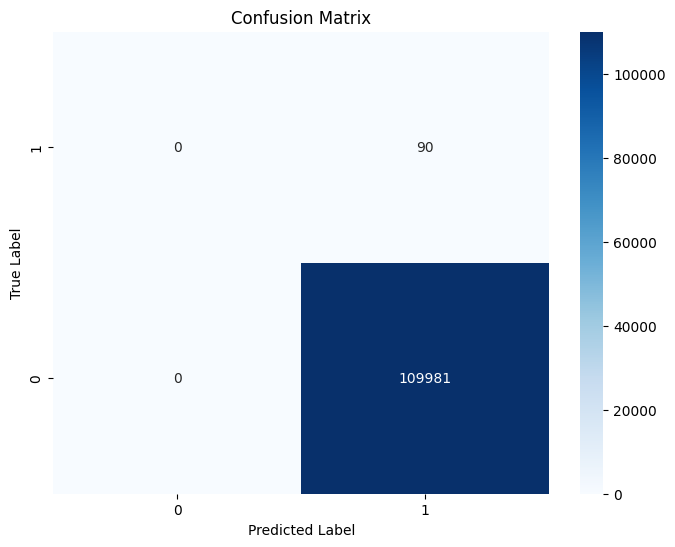

In [10]:
cm = confusion_matrix(y_test_seq, y_pred)

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(2), yticklabels=range(2))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.gca().invert_yaxis()
plt.show()